In [457]:
%load_ext autoreload
%autoreload 2
import contextlib
import pickle
import scipy.sparse
import random
import time
import os
import glob
from collections import defaultdict

# auto reload modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.neighbors import kneighbors_graph
import torch
import torch.nn as nn
import torch.optim as optim


# set seaborn style
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_palette('pastel')
sns.set_context('poster')
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data + Creation of weeks

In [458]:
data = pd.read_pickle("irise_weekly_and_refit.pk") # load data

CHUNK_SIZE = 168 # chunk size
refit, irise = data['refit'], data['irise'] # split data

refit_weekly = [{
    'X': {k: v.iloc[CHUNK_SIZE*week: CHUNK_SIZE*(week + 1)] for k, v in refit['X'].items()},
    'X_bar': refit['X_bar'].iloc[CHUNK_SIZE*week: CHUNK_SIZE*(week + 1)],
    }
    for week in range(len(refit['X_bar']) // CHUNK_SIZE) # create weeks
]

In [459]:
reshaped_irise = []
reshaped_refit = []
# IRISE data
for ind, week_data in enumerate(irise): # for each week
    current = dict() # create current dict
    for house in week_data['X']['TV'].columns: # for each house
        new_df = pd.concat(
            [week_data['X'][appliance][house] for appliance in week_data['X'].keys()] + [week_data['X_bar'][house]],
            axis = 1,
        )# concatenate data 
        new_df.columns = list(week_data['X'].keys()) + ['aggregate'] # rename columns
        current[house] = new_df # add to current dict
    reshaped_irise.append(current) # append to reshaped_irise

# REFIT data
for ind, week_data in enumerate(refit_weekly):
    current = dict()
    for house in week_data['X']['TV'].columns:
        new_df = pd.concat(
            [week_data['X'][appliance][house] for appliance in week_data['X'].keys()] + [week_data['X_bar'][house]],
            axis = 1,
        )# concatenate data 
        new_df.columns = list(week_data['X'].keys()) + ['aggregate'] # rename columns
        current[house] = new_df # add to current dict
    reshaped_refit.append(current) # append to reshaped_refit

    
combined_data_weekly = [
    {**reshaped_irise[week], **reshaped_refit[week]} for week in range(min(len(reshaped_irise), len(reshaped_refit))) # combine data
]

In [460]:
METHODS = ['REFIT only', 'IRISE only', 'REFIT train, IRISE test', 'REFIT+IRISE train, IRISE test'] 

def split_data(data_dict, method): # split data
    train_target_houses = ['irise_house_09', 'irise_house_34', 'irise_house_38', 'irise_house_14'] # target houses

    if method == 'REFIT only':
        houses = [x for x in data_dict.keys() if 'irise' not in x] # houses
        train_houses = random.sample(houses, 6) # train houses
        train = {k:v for k,v in data_dict.items() if k in train_houses} # train data
        test = {k:v for k,v in data_dict.items() if k in houses and k not in train_houses} # test data
        return train, test

    if method == 'IRISE only':
        houses = [x for x in data_dict.keys() if 'irise' in x]  
        train_houses = random.sample(houses, 2)
        train = {k:v.dropna() for k,v in data_dict.items() if k in train_houses}
        test = {k:v.dropna() for k,v in data_dict.items() if k in houses and k not in train_houses}
        return train, test

    if method == 'REFIT train, IRISE test':
        train = {k:v for k,v in data_dict.items() if 'irise' not in k}
        test = {k:v for k,v in data_dict.items() if 'irise' in k and k not in train_target_houses}
        return train, test

    if method == 'REFIT+IRISE train, IRISE test':
        houses = [x for x in data_dict.keys() if 'irise' not in x]
        train_houses = [x for x in data_dict.keys() if 'irise' not in x] + train_target_houses
        train = {k:v for k,v in data_dict.items() if k in train_houses}
        test = {k:v for k,v in data_dict.items() if k not in train_houses}
        return train, test


In [461]:
appliance_categories = ['fridge', 'washing_drying', 'TV', 'kitchen appliances'] 
weeks_to_train = 10 

model_params = {
    'input_dim': len(refit_weekly[0]['X']['fridge']),
    'hidden_dim1': 64,
    'hidden_dim2': 128,
    'code_dim': 256,
    'sparsity_penalty': 0.1,
}# model parameters

pipeline_params = {
    'max_iter_fl': 5,
}


#sparsity_penalty = 0.05
num_iterations = 100
lr = 0.01

training_params = {
    'weeks_to_train': 10,
    'learning_rate': 10**(-2),
    'max_iter_nn': 300,
}
# training function arguments
training_func_args = [
    model_params['input_dim'],
    model_params['hidden_dim1'],
    model_params['hidden_dim2'],
    model_params['code_dim'],
    model_params['sparsity_penalty'],
    num_iterations,
    lr,
]

agg_func_type = 'FedDA'
week = 0

# Autoencoder

In [462]:
class DeepSC(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim, sparsity_penalty, appliance):
        super(DeepSC, self).__init__()
        model_params['input_dim'] = input_dim
        model_params['hidden_dim1'] = hidden_dim1
        model_params['hidden_dim2'] = hidden_dim2
        model_params['code_dim'] = code_dim
        model_params['input_dim'] = input_dim
        self.sparsity_penalty = sparsity_penalty
        self.appliance = appliance
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim1, code_dim, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(code_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim1, input_dim, kernel_size=3, padding=1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        # Encoding
        enc = self.encoder(x)
        # Decoding
        dec = self.decoder(enc)
        return enc, dec
    
    def loss(self, x, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        sparsity_loss = self.sparsity_penalty * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = reconstruction_loss + sparsity_loss# + negativity_loss
        return x, loss, reconstruction_loss, sparsity_loss, negativity_loss


## Autoencoder training

In [463]:
def deep_sc_train_local_block(X, Y, appliance, input_dim, hidden_dim1, hidden_dim2, code_dim, sparsity_penalty, num_iterations, lr, global_state_dict=None):
    reconstructions = []
    sparsities = []
    losses = []
    # create model      
    model = DeepSC(input_dim, hidden_dim1, hidden_dim2, code_dim, sparsity_penalty, appliance)
    
    # load global model parameters
    if global_state_dict is not None:
        model.load_state_dict(global_state_dict)
    # set requires_grad to True
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.Adam(model.parameters(), lr) # optimizer
    # convert to tensor
    X = torch.tensor(X.values, dtype=torch.float32).T.unsqueeze(0).unsqueeze(2)
    Y = torch.tensor(Y.values, dtype=torch.float32).T.unsqueeze(0).unsqueeze(2)
    # training loop
    for i in range(num_iterations):
        print('iter', i)
        optimizer.zero_grad() # zero gradients
        enc, dec = model.forward(X) # forward pass
        x, loss, reconstruction_loss, sparsity_loss, negativity_loss  = model.loss(X, enc, dec, Y) # loss
        print('----> reconstruction loss', reconstruction_loss.detach().numpy()) # print loss
        print('----> sparsity loss', sparsity_loss.detach().numpy())
        print('----> negativity loss', negativity_loss.detach().numpy())
        print('----> total loss', loss.detach().numpy())
        loss.backward() # backward pass
        optimizer.step() # update parameters
    # append to lists
        reconstructions.append(reconstruction_loss.detach().numpy())
        sparsities.append(sparsity_loss.detach().numpy())
        losses.append(loss.detach().numpy())
            
        print('\n-----------------------------------------------------------------------------\n')
            
    return model, reconstructions, sparsities, losses, enc, dec



## Metrics

In [464]:
# Function to calculate disaggregation accuracy per appliance category
# Parameters:
#   y_apps: Dictionary of predicted power values for each appliance
#   y_true: Dictionary of true power values for each appliance 
#   x_bar: Total aggregate power consumption
# Returns:
#   - Array of accuracies per timestep
#   - Mean accuracy across all timesteps
#   - Dictionary of accuracies per appliance category

def dd_acc_cat(y_apps, y_true, x_bar):
    s = 0
    acc_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat]
        y_real = y_true[cat]
        s += np.sum(np.abs(y_real - y_app), axis=0)
        acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)
    den = 2*x_bar.sum(axis=0)
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}

# Function to calculate disaggregation accuracy per appliance category for non-zero values only
# Parameters:
#   y_apps: Dictionary of predicted power values for each appliance
#   y_true: Dictionary of true power values for each appliance
#   x_bar: Total aggregate power consumption
# Returns:
#   - Mean accuracy across all non-zero timesteps (rounded to 3 decimal places)

def dd_acc_cat_non_zero(y_apps, y_true, x_bar):
    s = 0
    total_acc = 0
    sum_diff = 0
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat]
        y_real = y_true[cat].values

        non_zero_inds = [ind for (ind, elt) in enumerate(y_real) if elt != 0] # np.nonzero(y_real)
        sub_real = y_real[non_zero_inds]
        sub_pred = y_app[non_zero_inds]
        sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))

    den = 2*x_bar.sum()
    total_acc += 1 - sum_diff/den

    return np.round(total_acc, 3)

# Function to calculate disaggregation error per appliance category
def dd_error_per_category(y_app, y_true):
    non_zero_inds = [ind for (ind, elt) in enumerate(y_true) if elt != 0]
    if len(non_zero_inds) == 0:
        # appliance not working the whole time
        return None, None
    return (
        np.sqrt(mean_squared_error(y_true, y_app)),
        np.sqrt(mean_squared_error(y_true, y_app))/np.linalg.norm(y_true, 2),
    )

# Function to calculate disaggregation error per appliance category for non-zero values only
# Parameters:
#   y_app: Dictionary of predicted power values for each appliance
#   y_true: Dictionary of true power values for each appliance
# Returns:
#   - Mean error across all non-zero timesteps (rounded to 3 decimal places)
def dd_error_non_zero_per_category(y_app, y_true):
    # when the appliance is working
    non_zero_inds = [ind for (ind, elt) in enumerate(y_true) if elt != 0]
    if len(non_zero_inds) == 0:
        # appliance not working the whole time
        return None, None
    y_true_non_zero = y_true[non_zero_inds]
    y_app_non_zero = y_app[non_zero_inds]
    
    return (
        np.sqrt(mean_squared_error(y_true_non_zero, y_app_non_zero)),
        np.sqrt(mean_squared_error(y_true_non_zero, y_app_non_zero))/np.linalg.norm(y_true_non_zero, 2),
    )

# Function to calculate on-off accuracy
# Parameters:
#   y_real: Array of true power values
#   y_pred: Array of predicted power values
#   threshold: Threshold for on-off classification
# Returns:
#   - On-off accuracy (rounded to 3 decimal places) 
def get_on_off_accuracy(y_real, y_pred, threshold=0):
    y_real_binary = [1 if x > threshold else 0 for x in y_real] # convert to binary
    y_pred_binary = [1 if x > threshold else 0 for x in y_pred] # convert to binary
    return accuracy_score(y_real_binary, y_pred_binary)



# Function to calculate disaggregation error per appliance category using Mean Absolute Error
# Parameters:
#   y_app: Array of predicted power values
#   y_true: Array of true power values
# Returns:
#   - Tuple of (MAE, normalized MAE) or (None, None) if appliance never turns on
#   - MAE is square root of mean absolute error
#   - Normalized MAE divides by L2 norm of true values
def dd_error_per_category_MAE(y_app, y_true):
    non_zero_inds = [ind for (ind, elt) in enumerate(y_true) if elt != 0]
    if len(non_zero_inds) == 0:
        # appliance not working the whole time
        return None, None
    return (
        np.sqrt(mean_absolute_error(y_true, y_app)),
        np.sqrt(mean_absolute_error(y_true, y_app))/np.linalg.norm(y_true, 2),
    )

# Function to calculate disaggregation error per appliance category using Mean Absolute Error,
# only considering timesteps when the appliance is on (non-zero power)
# Parameters:
#   y_app: Array of predicted power values
#   y_true: Array of true power values
# Returns:
#   - Tuple of (MAE, normalized MAE) or (None, None) if appliance never turns on
#   - MAE is square root of mean absolute error
#   - Normalized MAE divides by L2 norm of true values
def dd_error_non_zero_per_category_MAE(y_app, y_true):
    # when the appliance is working
    non_zero_inds = [ind for (ind, elt) in enumerate(y_true) if elt != 0]
    if len(non_zero_inds) == 0:
        # appliance not working the whole time
        return None, None
    y_true_non_zero = y_true[non_zero_inds]
    y_app_non_zero = y_app[non_zero_inds]
    
    return (
        np.sqrt(mean_absolute_error(y_true_non_zero, y_app_non_zero)),
        np.sqrt(mean_absolute_error(y_true_non_zero, y_app_non_zero))/np.linalg.norm(y_true_non_zero, 2),
    )

# Federated Learning Framework for Deep Learning

In [465]:
# FederatedNILM class implements federated learning for non-intrusive load monitoring
class FederatedNILM:
    def __init__(self, train, test, agg_funcs, aggregate_func_type, clients_data, test_data, 
                 appliance_categories, model, training_function, training_func_args, 
                 model_params, pipeline_params, reweighting_function=None):
        """Initialize FederatedNILM class for federated learning in NILM.
        
        Args:
            train: Training data
            test: Test data
            agg_funcs: Dictionary of aggregation functions
            aggregate_func_type: Type of aggregation function to use
            clients_data: Dictionary of client training data
            test_data: Dictionary of test data
            appliance_categories: List of appliance categories
            model: Neural network model class
            training_function: Function to train model
            training_func_args: Arguments for training function
            model_params: Parameters for model initialization
            pipeline_params: Parameters for federated learning pipeline
            reweighting_function: Optional function to reweight aggregation
        """
        self.clients_data = clients_data
        self.test_data = test_data
        self.appliance_categories = appliance_categories
        self.model = model
        self.training_function = training_function
        self.model_params = model_params
        self.pipeline_params = pipeline_params
        self.train = train
        self.test = test
        self.aggregate_func_type = aggregate_func_type
        self.ada_models = {}
        
        # Get aggregation function and weights
        (self.aggregate_func, self.agg_func_weights, self.reweighting_function) = \
            self.get_aggregate_func(agg_funcs, aggregate_func_type)
        
        print(f'Aggregate function is {aggregate_func_type}, fetched function {self.aggregate_func}, '
              f'func args are {self.agg_func_weights}')
        print(f'Re-weighting function is {self.reweighting_function}')
        
        self.training_func_args = training_func_args
        self.convergence_metrics = []
        
        # Initialize tracking variables
        self.last_encoder_outputs = defaultdict(dict)    
        self.last_local_predictions = defaultdict(dict)
        self.round_train_preds = []
        self.round_test_preds = []
        
    def get_aggregate_func(self, agg_funcs, aggregate_func_type):
        """Get aggregation function and initialize FedAda models if needed."""
        agg_func_tuple = agg_funcs.get(aggregate_func_type)
        
        if aggregate_func_type == 'FedAda':
            # Initialize adaptive aggregation models
            for category in self.appliance_categories:
                input_size = self.model_params['code_dim']  # Assuming code_dim matches encoder output
                self.ada_models[category] = nn.Sequential(
                    nn.Linear(input_size, 64),
                    nn.ReLU(),
                    nn.Linear(64, 1),
                    nn.Softmax(dim=0)
                )
            return agg_func_tuple
            
        if agg_func_tuple is None:
            raise KeyError(f'Invalid aggregate function, choose from list {list(agg_funcs.keys())}')
        return agg_func_tuple

    def run_fed_avg(self, training_func_args):
        """Run federated learning training loop."""
        # Initialize models
        self.appliance_models = self.initialize_models()
        
        current_global_state_dicts = {
            category: None for category in self.appliance_categories
        }
        
        # Training loop
        for t in range(self.pipeline_params['max_iter_fl']):
            print(f'FL Training round {t}')
            
            # Train local models
            local_appliance_models = dict()
            round_metrics = defaultdict(dict)
            
            for house, house_train in self.clients_data.items():
                print(f'Training on client {house}')
                with contextlib.redirect_stdout(None):
                    models, rec, spar, loss_dict, encoder_output, decoder_output = \
                        self.train_model_remotely(house_train, current_global_state_dicts, 
                                                training_func_args)
                
                # Store results
                local_appliance_models[house] = models
                round_metrics['Reconstruction'][house] = rec
                round_metrics['Sparsity'][house] = spar
                round_metrics['Total Loss'][house] = loss_dict
                self.last_encoder_outputs[house] = encoder_output
                self.last_local_predictions[house] = decoder_output
                
            self.convergence_metrics.append(round_metrics)
            print('Finished local round of houses')

            # Store local models and aggregate
            self.local_appliance_models = local_appliance_models
            
            if self.aggregate_func_type == 'FedAda':
                self._train_ada_models()
                
            self.appliance_models = self.aggregate_local_models()
            
            # Update global state
            current_global_state_dicts = {
                category: self.appliance_models[category].state_dict() 
                for category in self.appliance_categories
            }
            
            # Make predictions for current round
            self.round_train_preds.append(self.predict_all_train())
            self.round_test_preds.append(self.predict_all())
            
            # Update weights if needed
            if self.reweighting_function is not None:
                self.agg_func_weights = self.reweighting_function(
                    self.train,
                    self.appliance_categories,
                    precomputed_enc=self.last_encoder_outputs,
                )
            print(f"Current weights for fridge: {self.agg_func_weights['fridge']}")
            
        return self.appliance_models

    def _train_ada_models(self):
        """Train adaptive aggregation models using encoder outputs and losses."""
        for category in self.appliance_categories:
            # Collect training data
            encoder_outputs = []
            losses = []
            for house in self.clients_data:
                enc = self.last_encoder_outputs[house][category]
                loss = np.mean(self.convergence_metrics[-1]['Total Loss'][house][category])
                encoder_outputs.append(enc)
                losses.append(loss)
            
            # Prepare tensors
            X = torch.tensor(encoder_outputs, dtype=torch.float32)
            y = 1 / (torch.tensor(losses, dtype=torch.float32) + 1e-6)
            y = y / y.sum()  # Normalize weights
            
            # Train model
            optimizer = optim.Adam(self.ada_models[category].parameters(), lr=0.001)
            criterion = torch.nn.MSELoss()
            
            for epoch in range(100):
                optimizer.zero_grad()
                weights_pred = self.ada_models[category](X).squeeze()
                loss = criterion(weights_pred, y)
                loss.backward()
                optimizer.step()

    def initialize_models(self):
        """Initialize models for each appliance category."""
        return {
            category: self.model(*self.model_params.values(), category) 
            for category in self.appliance_categories
        }

    def train_model_remotely(self, house_train, current_global_state_dicts, training_func_args):
        """Train models for each appliance on a remote client."""
        models = {}
        rec = {}
        spar = {}
        loss_dict = {}
        encoder_output = {}
        decoder_output = {}
        
        for category in self.appliance_categories:
            print(f'Training {category}')
            model, reconstructions, sparsities, losses, enc, dec = self.training_function(
                house_train['aggregate'],
                house_train[category],
                category,
                *self.training_func_args,
                current_global_state_dicts[category],
            )
            
            models[category] = model
            rec[category] = reconstructions
            spar[category] = sparsities
            loss_dict[category] = losses
            encoder_output[category] = enc.squeeze().detach().numpy()
            decoder_output[category] = dec.squeeze().detach().numpy()

        return models, rec, spar, loss_dict, encoder_output, decoder_output

    def _ada_aggregation(self):
        """Perform adaptive aggregation using trained Ada models."""
        aggregated_models = {}
        
        for category in self.appliance_categories:
            # Get encoder outputs and predict weights
            encoder_outputs = [
                self.last_encoder_outputs[house][category] 
                for house in self.local_appliance_models
            ]
            
            with torch.no_grad():
                weights = self.ada_models[category](
                    torch.tensor(encoder_outputs, dtype=torch.float32)
                ).numpy()
            
            # Weighted aggregation
            global_state_dict = self.appliance_models[category].state_dict()
            for key in global_state_dict:
                weighted_params = [
                    local_model[category].state_dict()[key] * w
                    for (_, local_model), w in zip(self.local_appliance_models.items(), weights)
                ]
                global_state_dict[key] = torch.sum(torch.stack(weighted_params), dim=0)
            
            aggregated_models[category] = self.appliance_models[category]
            aggregated_models[category].load_state_dict(global_state_dict)
            
        return aggregated_models

    def aggregate_local_models(self):
        """Aggregate local models using specified aggregation strategy."""
        if self.aggregate_func_type == 'FedAda':
            return self._ada_aggregation()
            
        return {
            category: self.aggregate_func(
                {house: models[category] for house, models in self.local_appliance_models.items()},
                self.appliance_models[category],
                self.agg_func_weights[category]
            )
            for category in self.appliance_categories
        }

    def predict_all(self):
        """Make predictions on test data."""
        return self._predict(self.test_data)
    
    def predict_all_train(self):
        """Make predictions on training data."""
        return self._predict(self.clients_data)
        
    def _predict(self, data):
        """Helper method for making predictions."""
        predictions = defaultdict(dict)
        accs = {}
        non_zero_accs = {}
        errors = defaultdict(dict)
        errors_non_zero = defaultdict(dict)
        errors2 = defaultdict(dict)
        errors2_non_zero = defaultdict(dict)
        
        for house, house_data in data.items():
            for category in self.appliance_categories:
                print(f'Predicting {category} for house {house}')
                
                # Prepare input and get prediction
                X = torch.tensor(house_data['aggregate'].values, dtype=torch.float32) \
                    .T.unsqueeze(0).unsqueeze(2)
                pred = self.appliance_models[category].forward(X)[1].squeeze().detach().numpy()
                
                # Store predictions and calculate metrics
                predictions[house][category] = pred
                true_values = house_data[category].values
                
                errors[house][category] = dd_error_per_category(pred, true_values)
                errors_non_zero[house][category] = dd_error_non_zero_per_category(pred, true_values)
                errors2[house][category] = dd_error_per_category_MAE(pred, true_values)
                errors2_non_zero[house][category] = dd_error_non_zero_per_category_MAE(pred, true_values)
            
            # Calculate accuracy metrics
            accs[house] = dd_acc_cat(predictions[house], house_data, house_data['aggregate'].values)
            non_zero_accs[house] = dd_acc_cat_non_zero(predictions[house], house_data, 
                                                      house_data['aggregate'].values)
        
        return predictions, errors, errors_non_zero, accs, non_zero_accs, errors2, errors2_non_zero

## Aggregation functions

In [466]:

def FedAvg(local_models, global_model, weights=None):
    """
    Implements Federated Averaging (FedAvg) algorithm to aggregate local models into a global model.
    
    Args:
        local_models (dict): Dictionary of local models from different clients
        global_model: The global model to be updated
        weights (dict, optional): Not used in FedAvg but kept for API consistency
        
    Returns:
        global_model: Updated global model with averaged parameters
    """
    # Get the global model's state dictionary
    global_state_dict = global_model.state_dict()
    
    # For each layer/parameter in the model
    for key in global_state_dict.keys():
        # Stack all local models' parameters and take their mean
        local_params = torch.stack([
            local_model.state_dict()[key] 
            for local_model in local_models.values()
        ])
        global_state_dict[key] = torch.mean(local_params, dim=0)
    
    # Load the averaged parameters into the global model
    global_model.load_state_dict(global_state_dict)
    return global_model

def FedDA(local_models, global_model, weights):
    """
    Implements Federated Domain Adaptation (FedDA) algorithm to aggregate local models into a global model.
    
    Args:
        local_models (dict): Dictionary of local models from different clients
        global_model: The global model to be updated
        weights (list): List of weights for each local model
        
    Returns:
        global_model: Updated global model with weighted parameters
    """
    # Get the global model's state dictionary
    global_state_dict = global_model.state_dict()
    
    # For each layer/parameter in the model
    for key in global_state_dict.keys():
        # Stack all local models' parameters with their corresponding weights
        weighted_params = torch.stack([
            weights[ind] * local_model.state_dict()[key]
            for ind, local_model in enumerate(local_models.values())
        ])
        
        # Sum up the weighted parameters
        global_state_dict[key] = torch.sum(weighted_params, dim=0)
    
    # Load the weighted parameters into the global model
    global_model.load_state_dict(global_state_dict)
    return global_model


### Weight estimation functions

In [467]:
def estimate_DA_weights_from_raw_data(train, appliance_categories):
    """
    Estimates domain adaptation weights from raw appliance data.
    
    Args:
        train (dict): Dictionary containing training data for each house and appliance category
        appliance_categories (list): List of appliance categories to process
        
    Returns:
        dict: Dictionary of normalized weights for each appliance category and house
    """
    weights = defaultdict(dict)
    FedDA_weights = defaultdict(dict)
    
    for category in appliance_categories:
        # Calculate target domain statistics
        target_data = [train[house][category] for house in train.keys() if 'irise' in house]
        target_mean = np.mean(pd.concat(target_data, axis=1), axis=1)
        target_var = np.var(pd.concat(target_data))
        
        # Calculate weights for each house
        for house, house_data in train.items():
            source_data = train[house][category]
            distance = np.linalg.norm(source_data - target_mean) ** 2
            
            # Weight is inversely proportional to distance from target mean
            # Add target variance as regularization term
            weights[category][house] = target_var / (distance + target_var)
            
        # Normalize weights to sum to 1
        total_weight = sum(weights[category].values())
        FedDA_weights[category] = [w/total_weight for w in weights[category].values()]
        
    return FedDA_weights

def extract_DA_weights_from_sparsely_coded_data(train, appliance_categories, training_func_args=None, precomputed_enc=None):
    """
    Extracts domain adaptation weights from sparsely coded appliance data.
    
    Args:
        train (dict): Dictionary containing training data for each house and appliance category
        appliance_categories (list): List of appliance categories to process
        training_func_args (tuple, optional): Arguments for deep sparse coding training
        precomputed_enc (dict, optional): Pre-computed encoded data for each house/category
        
    Returns:
        dict: Dictionary of normalized weights for each appliance category and house
    """
    weights = defaultdict(dict)
    FedDA_weights = defaultdict(dict)
    
    # Use pre-computed encodings if provided, otherwise generate new ones
    encoder_data = precomputed_enc if precomputed_enc is not None else defaultdict(dict)
    
    # Generate encodings if not pre-computed
    if precomputed_enc is None:
        for category in appliance_categories:
            for house, house_data in train.items():
                try:
                    _, _, _, _, enc, _ = deep_sc_train_local_block(
                        house_data['aggregate'],
                        house_data[category],
                        category,
                        *training_func_args,
                    )
                    encoder_data[house][category] = enc.squeeze().detach().numpy()
                except Exception as e:
                    print(f"Error encoding data for house {house}, category {category}: {str(e)}")
                    continue
    
    # Calculate weights for each category
    for category in appliance_categories:
        # Get target domain data (IRISE houses)
        target_houses = [h for h in train.keys() if 'irise' in h]
        target_encodings = [encoder_data[h][category] for h in target_houses]
        
        # Calculate target statistics
        target_mean = np.mean(pd.DataFrame(target_encodings).T, axis=1)
        target_var = np.var(pd.concat([pd.Series(enc) for enc in target_encodings]))
        
        # Calculate weights for each house based on distance to target mean
        for house in train.keys():
            try:
                distance = np.linalg.norm(encoder_data[house][category] - target_mean) ** 2
                weights[category][house] = target_var / (distance + target_var)
            except KeyError:
                print(f"Missing encoding for house {house}, category {category}")
                weights[category][house] = 0
                
        # Normalize weights to sum to 1
        total_weight = sum(weights[category].values())
        if total_weight > 0:
            FedDA_weights[category] = [w/total_weight for w in weights[category].values()]
        else:
            print(f"Warning: Zero total weight for category {category}")
            FedDA_weights[category] = [1.0/len(weights[category])] * len(weights[category])
            
    return FedDA_weights
def rbf_kernel(x, y, gamma):
    """
    Compute the Radial Basis Function (RBF) kernel between two vectors.
    
    Args:
        x (numpy.ndarray): First input vector
        y (numpy.ndarray): Second input vector  
        gamma (float): RBF kernel bandwidth parameter. Controls how fast the similarity 
                      decays with distance between points.
    
    Returns:
        float: RBF kernel value between x and y, ranges from 0 to 1
               1 means x and y are identical
               0 means x and y are very different
    """
    if gamma <= 0:
        raise ValueError("Gamma parameter must be positive")
        
    try:
        distance = np.linalg.norm(x - y) ** 2
        return np.exp(-gamma * distance)
    except:
        raise ValueError("Inputs x and y must be numpy arrays of same shape")




def create_RBF_matrix(data_list, gamma=1):
    """
    Create an RBF kernel matrix for a list of data points.
    
    Args:
        data_list (list of numpy.ndarray): List of input vectors
        gamma (float): RBF kernel bandwidth parameter. Controls how fast the similarity 
                      decays with distance between points.
    
    Returns:
        numpy.ndarray: RBF kernel matrix where element (i, j) represents the RBF kernel value between data_list[i] and data_list[j]
    """
    rbf_matrix = np.ndarray((len(data_list), len(data_list)))
    for i, data in enumerate(data_list[:-1]):
        rbf_matrix[i, i] = 1
        for j in range(i+1, len(data_list)):
            rbf_matrix[i, j] = rbf_kernel(data, data_list[j], gamma)
            rbf_matrix[j, i] = rbf_matrix[i, j]
    rbf_matrix[-1, -1] = 1  # Ensure the last diagonal element is set to 1
    return rbf_matrix

def extract_RBF_weights_from_sparsely_coded_data(train, appliance_categories, training_func_args=None, precomputed_enc=None, gamma=1e-5):
    """
    Extract RBF weights from sparsely coded data.
    
    Args:
        train (dict): Dictionary containing training data for each house
        appliance_categories (list): List of appliance categories
        training_func_args (tuple, optional): Arguments for the training function
        precomputed_enc (dict, optional): Precomputed encodings for each house and category
        gamma (float): RBF kernel bandwidth parameter. Controls how fast the similarity 
                      decays with distance between points.
    
    Returns:
        dict: Dictionary containing RBF weights for each appliance category
    """
    FedRBF_weights = defaultdict(dict)
    
    # Use precomputed encodings if provided
    encoder_data = precomputed_enc
    
    # Compute encodings if not provided
    if precomputed_enc is None:
        encoder_data = defaultdict(dict)
        for category in appliance_categories:
            for house, house_data in train.items():
                _, _, _, _, enc, _ = deep_sc_train_local_block(
                        house_data['aggregate'],
                        house_data[category],
                        category,
                        *training_func_args,
                    )
                encoder_data[house][category] = enc.squeeze().detach().numpy()
            
    for category in appliance_categories:
        inp = [h[category] for h in list(encoder_data.values())]
        rbf_matrix = create_RBF_matrix(inp, gamma)
        print(rbf_matrix)
        target_inds = [i for i, h in enumerate(list(train.keys())) if 'irise' in h]
        w = np.mean(rbf_matrix[target_inds], axis=0)
        FedRBF_weights[category] = w / np.sum(w)
    return FedRBF_weights

def estimate_RBF_weights_from_raw_data(train, appliance_categories, gamma=1e-5):
    """
    Estimate RBF weights from raw data.
    
    Args:
        train (dict): Dictionary containing training data for each house
        appliance_categories (list): List of appliance categories
        gamma (float): RBF kernel bandwidth parameter. Controls how fast the similarity 
                      decays with distance between points.
    
    Returns:
        dict: Dictionary containing RBF weights for each appliance category
    """
    FedRBF_weights = defaultdict(dict)
    for category in appliance_categories:
        inp = [h[category] for h in list(train.values())]
        rbf_matrix = create_RBF_matrix(inp, gamma)
        print(rbf_matrix)
        target_inds = [i for i, h in enumerate(list(train.keys())) if 'irise' in h]
        w = np.mean(rbf_matrix[target_inds], axis=0)
        FedRBF_weights[category] = w / np.sum(w)
    return FedRBF_weights

def MMD(X, Y, gamma):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two datasets X and Y using an RBF kernel.

    Args:
        X (np.ndarray): Source dataset, shape (n_samples, n_features) or (n_samples,).
        Y (np.ndarray): Target dataset, shape (n_samples, n_features) or (n_samples,).
        gamma (float): Kernel bandwidth parameter for the RBF kernel.

    Returns:
        float: The MMD value between the two datasets.
    """
    # Ensure X and Y are 2D arrays
    X = X[:, np.newaxis] if len(X.shape) == 1 else X
    Y = Y[:, np.newaxis] if len(Y.shape) == 1 else Y

    # Get the number of samples in each dataset
    m, n = X.shape[1], Y.shape[1]

    # Initialize kernel values
    source_kernel_value = 1 if m == 1 else 0
    target_kernel_value = 1 if n == 1 else 0

    # Compute the source kernel value if there are multiple samples
    if m > 1:
        source_kernel_value = sum(rbf_kernel(X[:, i], X[:, j], gamma) for i in range(m) for j in range(m) if i != j) / (m * (m - 1))

    # Compute the target kernel value if there are multiple samples
    if n > 1:
        target_kernel_value = sum(rbf_kernel(Y[:, i], Y[:, j], gamma) for i in range(n) for j in range(n) if i != j) / (n * (n - 1))

    # Compute the cross-kernel value between source and target
    s_t_value = 2 * sum(rbf_kernel(X[:, i], Y[:, j], gamma) for i in range(m) for j in range(n)) / (m * n)

    # Return the MMD value
    return np.sqrt(np.abs(source_kernel_value + target_kernel_value - s_t_value))

def create_MMD_matrix(data_list, gamma=1):
    """
    Create a Maximum Mean Discrepancy (MMD) matrix for a list of data arrays.

    Args:
        data_list (list): List of data arrays to compute MMD between.
        gamma (float): Kernel bandwidth parameter for MMD computation.

    Returns:
        np.ndarray: A symmetric matrix where each element (i, j) represents the MMD between data_list[i] and data_list[j].
    """
    n = len(data_list)
    mmd_matrix = np.zeros((n, n))  # Initialize with zeros for clarity
    for i in range(n):
        for j in range(i+1, n):
            mmd_value = MMD(data_list[i], data_list[j], gamma)
            mmd_matrix[i, j] = mmd_value
            mmd_matrix[j, i] = mmd_value  # Ensure symmetry
    return mmd_matrix

def extract_MMD_weights_from_sparsely_coded_data(train, appliance_categories, training_func_args=None, precomputed_enc=None, gamma=1e-5):
    """
    Extract MMD weights from sparsely coded data using precomputed encodings or by computing them.

    Args:
        train (dict): Training data for each house.
        appliance_categories (list): List of appliance categories.
        training_func_args (tuple): Arguments for the training function.
        precomputed_enc (dict): Precomputed encodings, if available.
        gamma (float): Kernel bandwidth parameter for MMD computation.

    Returns:
        dict: Dictionary containing MMD weights for each appliance category.
    """
    FedMMD_weights = defaultdict(dict)
    encoder_data = precomputed_enc or defaultdict(dict)

    if precomputed_enc is None:
        for category in appliance_categories:
            for house, house_data in train.items():
                _, _, _, _, enc, _ = deep_sc_train_local_block(
                    house_data['aggregate'],
                    house_data[category],
                    category,
                    *training_func_args,
                )
                encoder_data[house][category] = enc.squeeze().detach().numpy()

    for category in appliance_categories:
        target = np.array([house_data[category] for h, house_data in encoder_data.items() if 'irise' in h]).T
        source = np.array([house_data[category] for h, house_data in encoder_data.items() if 'irise' not in h]).T
        mmd = MMD(source, target, gamma)
        w = np.array([mmd if 'irise' not in h else 1 for h in train.keys()])
        FedMMD_weights[category] = w / np.sum(w)
    return FedMMD_weights

def estimate_MMD_weights_from_raw_data(train, appliance_categories, gamma=1):
    """
    Estimate MMD weights directly from raw training data.

    Args:
        train (dict): Training data for each house.
        appliance_categories (list): List of appliance categories.
        gamma (float): Kernel bandwidth parameter for MMD computation.

    Returns:
        dict: Dictionary containing MMD weights for each appliance category.
    """
    FedMMD_weights = defaultdict(dict)
    for category in appliance_categories:
        target = np.array([house_data[category] for h, house_data in train.items() if 'irise' in h]).T
        source = np.array([house_data[category] for h, house_data in train.items() if 'irise' not in h]).T
        mmd = MMD(source, target, gamma)
        w = np.array([mmd if 'irise' not in h else 1 for h in train.keys()])
        FedMMD_weights[category] = w / np.sum(w)
    return FedMMD_weights

def extract_kNN_weights_from_sparsely_coded_data(train, appliance_categories, training_func_args=None, precomputed_enc=None):
    """
    Extract k-Nearest Neighbors (kNN) weights from sparsely coded data using precomputed encodings or by computing them.

    Args:
        train (dict): Training data for each house.
        appliance_categories (list): List of appliance categories.
        training_func_args (tuple): Arguments for the training function.
        precomputed_enc (dict): Precomputed encodings, if available.

    Returns:
        dict: Dictionary containing kNN weights for each appliance category.
    """
    FedkNN_weights = defaultdict(dict)
    encoder_data = precomputed_enc or defaultdict(dict)

    if precomputed_enc is None:
        for category in appliance_categories:
            for house, house_data in train.items():
                _, _, _, _, enc, _ = deep_sc_train_local_block(
                    house_data['aggregate'],
                    house_data[category],
                    category,
                    *training_func_args,
                )
                encoder_data[house][category] = enc.squeeze().detach().numpy()

    for category in appliance_categories:
        inp = [h[category] for h in encoder_data.values()]
        knn_matrix = get_kNN_matrix(inp)
        target_inds = [i for i, h in enumerate(train.keys()) if 'irise' in h]
        w = np.mean(knn_matrix[target_inds], axis=0)
        FedkNN_weights[category] = w / np.sum(w)
    return FedkNN_weights

def estimate_kNN_weights_from_raw_data(train, appliance_categories):
    """
    Estimate kNN weights directly from raw training data.

    Args:
        train (dict): Training data for each house.
        appliance_categories (list): List of appliance categories.

    Returns:
        dict: Dictionary containing kNN weights for each appliance category.
    """
    FedkNN_weights = defaultdict(dict)
    for category in appliance_categories:
        inp = [h[category] for h in train.values()]
        knn_matrix = get_kNN_matrix(inp)
        target_inds = [i for i, h in enumerate(train.keys()) if 'irise' in h]
        w = np.mean(knn_matrix[target_inds], axis=0)
        FedkNN_weights[category] = w / np.sum(w)
    return FedkNN_weights

def get_kNN_matrix(list_train):
    """
    Generate a k-Nearest Neighbors (kNN) adjacency matrix for a list of training data.

    Args:
        list_train (list): List of training data arrays.

    Returns:
        np.ndarray: A kNN adjacency matrix where each element (i, j) indicates the presence of a kNN relationship.
    """
    K = kneighbors_graph(list_train, n_neighbors=4).todense()
    return np.array(K)



### Training functions

In [468]:
def train_fl_on_data(train, test, model_params, pipeline_params, training_params, training_func_args, agg_funcs, aggregate_func_type="FedAvg"):
    """
    Train a federated learning model on the provided training and test data.

    Args:
        train (dict): Training data for each client.
        test (dict): Test data for each client.
        model_params (dict): Parameters for the model.
        pipeline_params (dict): Parameters for the data pipeline.
        training_params (dict): Parameters for the training process.
        training_func_args (dict): Additional arguments for the training function.
        agg_funcs (list): List of aggregation functions to be used.
        aggregate_func_type (str): Type of aggregation function to use. Default is "FedAvg".

    Returns:
        dict: A dictionary containing predictions and errors for both training and test datasets.
    """
    # Initialize the federated learning method with the given parameters
    FedMethod = FederatedNILM(
        train=train,
        test=test,
        agg_funcs=agg_funcs,
        aggregate_func_type=aggregate_func_type,
        clients_data=train,
        test_data=test,
        appliance_categories=appliance_categories,
        model=DeepSC,
        training_function=deep_sc_train_local_block,
        training_func_args=training_func_args,
        model_params=model_params,
        pipeline_params=pipeline_params,
    )
    
    # Run the federated averaging process
    FedMethod.run_fed_avg(training_func_args)
    
    # Obtain predictions and errors for the test dataset
    predictions, errors, non_zero_errors, accs, non_zero_accs,errors2,errors2_non_zero = FedMethod.predict_all()
    
    # Obtain predictions and errors for the training dataset
    predictions_train, errors_train, non_zero_errors_train, accs_train, non_zero_accs_train,errors2_train,errors2_non_zero_train = FedMethod.predict_all_train()    
    # Return a dictionary containing both training and test results

    return {
        'train': (predictions_train, errors_train, non_zero_errors_train, accs_train, non_zero_accs_train,FedMethod.round_train_preds,errors2_train,errors2_non_zero_train),
        'test': (predictions, errors, non_zero_errors, accs, non_zero_accs,FedMethod.round_test_preds,errors2,errors2_non_zero),
    }


In [469]:
def extract_Ada_weights_from_sparsely_coded_data(weights_list, train, category, training_func_args=None):
    """
    Extracts adaptive weights from sparsely coded data using a simple neural network.

    Args:
        weights_list (list): List of weight dictionaries for each method.
        train (dict): Training data for each client.
        category (str): The category of appliance for which weights are extracted.
        training_func_args (dict, optional): Additional arguments for the training function.

    Returns:
        tuple: A dictionary of adaptive weights for each category and the final loss value.
    """
    FedAda_weights = defaultdict(dict)
    loss = 1

    for category in appliance_categories:
        # Extract weights for the current category from each method
        method_weights = [w[category] for w in weights_list]

        # Convert the list of weights to a tensor
        weights_tensor = torch.tensor(method_weights, dtype=torch.float32)

        # Define a simple 2-layer neural network to combine weights
        hidden_size = 320
        nn_layer1 = torch.nn.Linear(len(method_weights), hidden_size)
        nn_layer11 = torch.nn.Linear(hidden_size, hidden_size)
        relu = torch.nn.ReLU()
        nn_layer2 = torch.nn.Linear(hidden_size, 1)

        # Initialize the optimizer
        optimizer = torch.optim.Adam([
            {'params': nn_layer1.parameters()},
            {'params': nn_layer2.parameters()}
        ], lr=0.0001)

        # Training loop to optimize the neural network
        while loss > 0.0001:
            optimizer.zero_grad()

            # Forward pass through the network
            hidden = relu(nn_layer1(weights_tensor.T))
            combined_weights = torch.sigmoid(nn_layer2(hidden)).squeeze()

            # Calculate the loss using Mean Squared Error (MSE)
            target_inds = [i for i, h in enumerate(list(train.keys()))]
            target_weights = torch.zeros_like(combined_weights)
            target_weights[target_inds] = 1.0 / len(target_inds)
            loss = torch.nn.MSELoss()(combined_weights, target_weights)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

        # Compute the final weights after training
        with torch.no_grad():
            hidden = relu(nn_layer1(weights_tensor.T))
            combined_weights = torch.sigmoid(nn_layer2(hidden)).squeeze()
            FedAda_weights[category] = (combined_weights / combined_weights.sum()).numpy()

    return FedAda_weights, loss


In [470]:
def get_data_for_week(week):
    # Define the method for data splitting
    method = 'REFIT+IRISE train, IRISE test'

    # Split the combined data into training and testing datasets based on the specified method
    train, test = split_data(combined_data_weekly[week], method)

    # Calculate the number of target samples in the training data
    len_target = sum(1 for h in train.keys() if 'irise' in h)

    # Calculate the number of source samples in the training data
    len_source = len(train.keys()) - len_target

    # Create a dictionary of weights for target-only training
    target_only_weights = {
        category: [1/len_target if 'irise' in h else 0 for h in train.keys()]
        for category in appliance_categories
    }

    # Create a dictionary of weights for source-only training
    source_only_weights = {
        category: [0 if 'irise' in h else 1/len_source for h in train.keys()]
        for category in appliance_categories
    }

    # Suppress output during weight estimation
    with contextlib.redirect_stdout(None):
        # Estimate weights using different methods
        FedDA_weights = estimate_DA_weights_from_raw_data(train, appliance_categories)
        FedDA_autoenc_weights = extract_DA_weights_from_sparsely_coded_data(train, appliance_categories, training_func_args)

        FedRBF_weights = estimate_RBF_weights_from_raw_data(train, appliance_categories, gamma=1e-5)
        FedRBF_autoenc_weights = extract_RBF_weights_from_sparsely_coded_data(
            train, appliance_categories, training_func_args, None, 1e-1
        )
        FedMMD_weights = estimate_MMD_weights_from_raw_data(train, appliance_categories, gamma=1e-5)
        FedMMD_autoenc_weights = extract_MMD_weights_from_sparsely_coded_data(
            train, appliance_categories, training_func_args, None, 1e-5
        )
        FedkNN_weights = estimate_kNN_weights_from_raw_data(train, appliance_categories)
        FedkNN_autoenc_weights = extract_kNN_weights_from_sparsely_coded_data(
            train, appliance_categories, training_func_args
        )
        FedAda_autoenc_weights = extract_Ada_weights_from_sparsely_coded_data(
            [FedDA_autoenc_weights, FedRBF_autoenc_weights, FedMMD_autoenc_weights, FedkNN_autoenc_weights],
            train, appliance_categories, training_func_args
        )

    # Concatenate weights from different methods for each category
    unconcatenated_weights = [FedDA_autoenc_weights, FedRBF_autoenc_weights, FedMMD_autoenc_weights, FedkNN_autoenc_weights, FedAda_autoenc_weights[0]]
    concatenated_weights = {
        category: np.concatenate([d[category] for d in unconcatenated_weights], axis=0)
        for category in FedDA_autoenc_weights.keys()
    }
    # Define a dictionary to map aggregation function names to their corresponding functions, weights, and reweighting functions.
    agg_funcs = {
        # FedAvg uses a simple averaging method with no specific weights or reweighting function.
        'FedAvg': (FedAvg, {c: None for c in appliance_categories}, None),
        
        # Fed_target_only uses FedDA with weights specific to target-only training.
        'Fed_target_only': (FedDA, target_only_weights, None),
        
        # Fed_source_only uses FedDA with weights specific to source-only training.
        'Fed_source_only': (FedDA, source_only_weights, None),
        
        # FedDA uses domain adaptation weights estimated from raw data.
        'FedDA': (FedDA, FedDA_weights, None),
        
        # FedDA_autoenc uses autoencoder-based domain adaptation weights.
        'FedDA_autoenc': (FedDA, FedDA_autoenc_weights, None),
        
        # FedDA_autoenc_reweight uses autoencoder-based weights with a reweighting function.
        'FedDA_autoenc_reweight': (FedDA, FedDA_autoenc_weights, extract_DA_weights_from_sparsely_coded_data),
        
        # FedRBF uses RBF kernel-based weights estimated from raw data.
        'FedRBF': (FedDA, FedRBF_weights, None),
        
        # FedRBF_autoenc uses autoencoder-based RBF kernel weights.
        'FedRBF_autoenc': (FedDA, FedRBF_autoenc_weights, None),
        
        # FedRBF_autoenc_reweight uses autoencoder-based RBF weights with a reweighting function.
        'FedRBF_autoenc_reweight': (FedDA, FedRBF_autoenc_weights, extract_RBF_weights_from_sparsely_coded_data),
        
        # FedMMD uses MMD-based weights estimated from raw data.
        'FedMMD': (FedDA, FedMMD_weights, None),
        
        # FedMMD_autoenc uses autoencoder-based MMD weights.
        'FedMMD_autoenc': (FedDA, FedMMD_autoenc_weights, None),
        
        # FedMMD_autoenc_reweight uses autoencoder-based MMD weights with a reweighting function.
        'FedMMD_autoenc_reweight': (FedDA, FedMMD_autoenc_weights, extract_MMD_weights_from_sparsely_coded_data),
        
        # FedkNN uses k-Nearest Neighbors-based weights estimated from raw data.
        'FedkNN': (FedDA, FedkNN_weights, None),
        
        # FedkNN_autoenc uses autoencoder-based k-Nearest Neighbors weights.
        'FedkNN_autoenc': (FedDA, FedkNN_autoenc_weights, None),
        
        # FedkNN_autoenc_reweight uses autoencoder-based k-Nearest Neighbors weights with a reweighting function.
        'FedkNN_autoenc_reweight': (FedDA, FedkNN_autoenc_weights, extract_kNN_weights_from_sparsely_coded_data),

        # FedAda uses adaptive autoencoder-based weights.
        'FedAda': (FedDA, concatenated_weights, None),

    }
    return agg_funcs,train,test

In [471]:
def output_results_for_week(week):
    """
    This function runs experiments for each aggregation function type defined in agg_funcs.
    It calculates the weight sum for each appliance category, trains the model, and records the time taken for each experiment.
    
    Returns:
        result_dict (dict): A dictionary containing the results of the experiments for each aggregation function type.
        time_dict (dict): A dictionary containing the time taken for each experiment.
    """
    time_dict = dict()  # Dictionary to store the time taken for each experiment
    result_dict = dict()  # Dictionary to store the results of each experiment
    agg_funcs,train,test = get_data_for_week(week) # get the data for the current week
    for agg_func_type in agg_funcs.keys():
        print('Experiments for {}'.format(agg_func_type))
        
        # Calculate and print the weight sum for each appliance category
        weight_sums = [np.sum(agg_funcs[agg_func_type][1][category]) for category in appliance_categories]
        print('weight sum:', weight_sums)
        
        # Record the start time of the experiment
        t0 = time.time()
        
        # Train the model and store the results
        result_dict[agg_func_type] = train_fl_on_data(
            train, test, model_params, pipeline_params, training_params, training_func_args, agg_funcs, agg_func_type
        )
        
        # Record the time taken for the experiment
        time_dict[agg_func_type] = time.time() - t0
    
    return result_dict, time_dict


In [472]:
def get_on_off_table_for_data_chunk(res, data, data_type):
    """
    Generates a pivot table showing the on/off accuracy for each appliance category and method.

    Args:
        res (dict): A dictionary containing the results of the experiments for each method.
        data (dict): A dictionary containing the true data for each house and appliance category.
        data_type (str): The type of data to be used (e.g., 'test', 'train').

    Returns:
        pd.DataFrame: A pivot table with methods as rows, appliance categories as columns, and on/off accuracy as values.
    """
    onoff_df = []  # List to store on/off accuracy data
    # Extract appliance categories from the results dictionary
    appliance_categories = list(res['FedAvg']['test'][0].values())[0].keys()
    
    # Iterate over each method in the results
    for method in res.keys():
        # Iterate over each appliance category
        for category in appliance_categories:
            onoff = []  # List to store on/off accuracy for each house
            # Iterate over each house in the data
            for house, house_data in data.items():
                y_true = house_data[category]  # True values for the appliance category
                y_pred = res[method][data_type][0][house][category]  # Predicted values
                # Calculate on/off accuracy and append to the list
                onoff.append(get_on_off_accuracy(y_true, y_pred, threshold=0))
            # Append the mean on/off accuracy for the current category and method
            onoff_df.append((category, method, np.mean(onoff)))
    
    # Convert the list to a DataFrame
    onoff_df = pd.DataFrame(onoff_df, columns=['Appliance', 'Method', 'on_off_accuracy'])
    # Create a pivot table with methods as rows and appliance categories as columns
    pivot_df = onoff_df.pivot(index='Method', columns='Appliance', values='on_off_accuracy')
    
    return pivot_df

In [473]:
def package_results(results, appliance_categories, data_partition='test'):
    """
    Packages the results of the experiments into structured data tables.

    Args:
        results (dict): A dictionary containing the results of the experiments for each aggregation function type.
        appliance_categories (list): A list of appliance categories to be considered.
        data_partition (str): The data partition to be used (e.g., 'test', 'train'). Default is 'test'.

    Returns:
        tuple: A tuple containing DataFrames for error, non-zero error, accuracy, error MAE, and non-zero error MAE.
    """
    # Initialize dictionaries to store results
    error_table = {}
    non_zero_error_table = {}
    error_table_MAE = {}
    non_zero_error_table_MAE = {}
    acc_table = {}

    # Iterate over each aggregation function type in the results
    for agg_func_type, metrics in results.items():
        metric_dict = metrics[data_partition]

        # Calculate mean error for each appliance category
        error = [
            np.mean(
                [metric_dict[1][h][category][1] for h in metric_dict[1] if metric_dict[1][h][category][1] is not None],
                axis=0
            )
            for category in appliance_categories
        ]

        # Calculate mean non-zero error for each appliance category
        non_zero_error = [
            np.mean(
                [metric_dict[2][h][category][1] for h in metric_dict[1] if metric_dict[2][h][category][1] is not None],
                axis=0
            )
            for category in appliance_categories
        ]

        # Calculate mean accuracy
        accuracy = np.mean([metric_dict[3][h][0] for h in metric_dict[3]])

        # Calculate mean error MAE for each appliance category
        error_MAE = [
            np.mean(
                [metric_dict[-1][h][category][1] for h in metric_dict[1] if metric_dict[-1][h][category][1] is not None],
                axis=0
            )
            for category in appliance_categories
        ]

        # Calculate mean non-zero error MAE for each appliance category
        non_zero_error_MAE = [
            np.mean(
                [metric_dict[-2][h][category][1] for h in metric_dict[1] if metric_dict[-2][h][category][1] is not None],
                axis=0
            )
            for category in appliance_categories
        ]

        # Store calculated values in respective tables
        error_table[agg_func_type] = error
        non_zero_error_table[agg_func_type] = non_zero_error
        acc_table[agg_func_type] = accuracy
        error_table_MAE[agg_func_type] = error_MAE
        non_zero_error_table_MAE[agg_func_type] = non_zero_error_MAE

    # Return the results as DataFrames
    return (
        pd.DataFrame(error_table, index=appliance_categories),
        pd.DataFrame(non_zero_error_table, index=appliance_categories),
        pd.DataFrame(list(acc_table.values()), index=acc_table.keys(), columns=['Accuracy']),
        pd.DataFrame(error_table_MAE, index=appliance_categories),
        pd.DataFrame(non_zero_error_table_MAE, index=appliance_categories),
    )

In [474]:
# Initialize a list to store results for each week
all_results = []

# Define the weeks to process; currently only week 0
weeks = [0, 2, 3, 5, 6, 7, 8, 9, 10, 12]
# Iterate over each week
for week in weeks:
    try:
        # Record the start time for processing the week
        t0 = time.time()
        
        # Call the function to output results for the current week
        res_output = output_results_for_week(week)
        
        # Append the results to the all_results list
        all_results.append(res_output)
        
        # Print the processing time for the current week
        print(f'Processed week {week}, took {round(time.time() - t0)}s')
    except Exception as e:
        # Print an error message if processing fails
        print(f'Could not process week {week}: {e}')
        continue

# Extract results and timing information from all_results
results = [x[0] for x in all_results]
time_dicts = [x[1] for x in all_results]

# Initialize lists to store average dataframes
avg_error_df, avg_nonzero_error_df, avg_acc_df,MAEs,MAEs_nonzero = [], [], [], [], []
onoff_df = []

# Process each result to calculate and store metrics
for res in results:
    # Package results into dataframes for error, non-zero error, and accuracy
    error_df, nonzero_error_df, acc_df,MAEs_df,MAEs_nonzero_df = package_results(res, appliance_categories, data_partition='test')
    
    # Append the dataframes to their respective lists
    avg_error_df.append(error_df)
    avg_nonzero_error_df.append(nonzero_error_df)
    avg_acc_df.append(acc_df)
    MAEs.append(MAEs_df)
    MAEs_nonzero.append(MAEs_nonzero_df)
    # Get the index list from the first accuracy dataframe
    inds = avg_acc_df[0].index.tolist()
    
    # Append the on/off table for the data chunk to the onoff_df list
    onoff_df.append(get_on_off_table_for_data_chunk(res, test, 'test'))



Experiments for FedAvg
weight sum: [None, None, None, None]
Aggregate function is FedAvg, fetched function <function FedAvg at 0x0000018E0B46D3A0>, func args are {'fridge': None, 'washing_drying': None, 'TV': None, 'kitchen appliances': None}
Re-weighting function is None
FL Training round 0
Training on client irise_house_09
Training on client irise_house_34
Training on client irise_house_38
Training on client irise_house_14
Training on client house_0
Training on client house_1
Training on client house_2
Training on client house_3
Training on client house_4
Training on client house_5
Training on client house_6
Training on client house_7
Training on client house_8
Training on client house_9
Training on client house_10
Training on client house_11
Training on client house_12
Training on client house_13
Training on client house_14
Finished local round of houses
Predicting fridge for house irise_house_09
Predicting washing_drying for house irise_house_09
Predicting TV for house irise_house_

In [475]:
nrmse_df = pd.concat(avg_error_df).groupby(level=0).mean()
nrmse_df = nrmse_df[inds]
nrmse_df = nrmse_df.applymap(lambda x: f'{round(x * 100, 2)}%')
nrmse_df


FedAvg Fed_target_only Fed_source_only  FedDA  \
TV                  10.24%           6.37%          14.95%  6.33%   
fridge              12.35%           6.25%          16.48%  6.11%   
kitchen appliances   7.72%           8.67%           7.81%  7.71%   
washing_drying       8.53%           9.02%           9.67%  7.76%   

                   FedDA_autoenc FedDA_autoenc_reweight FedRBF FedRBF_autoenc  \
TV                         6.45%                   6.6%  6.48%          6.59%   
fridge                     7.06%                   6.7%   6.2%          6.63%   
kitchen appliances         7.71%                  8.05%  7.71%          7.71%   
washing_drying             8.34%                  8.27%  8.07%          8.25%   

                   FedRBF_autoenc_reweight  FedMMD FedMMD_autoenc  \
TV                                  10.32%   9.14%          6.31%   
fridge                              12.69%  11.57%          6.11%   
kitchen appliances                   7.75%   7.72%          8.61%   
washing_drying                       7.79%    8.7%          9.18%   

                   FedMMD_autoenc_reweight FedkNN FedkNN_autoenc  \
TV                                   6.37%  6.35%          6.26%   
fridge                               6.18%   6.4%          6.47%   
kitchen appliances                   8.61%  7.71%          7.71%   
washing_drying                       9.27%  7.82%          8.47%   

                   FedkNN_autoenc_reweight FedAda  
TV                                   6.55%  4.59%  
fridge                               6.55%  4.38%  
kitchen appliances                   7.74%   5.1%  
washing_drying                       7.72%  6.63%

In [476]:
nrmse_df = pd.concat(avg_nonzero_error_df).groupby(level=0).mean()
nrmse_df = nrmse_df[inds]
nrmse_df = nrmse_df.applymap(lambda x: f'{round(x * 100, 2)}%')

nrmse_df

FedAvg Fed_target_only Fed_source_only   FedDA  \
TV                   9.68%           7.83%          13.41%   7.94%   
fridge              10.42%           5.69%          14.58%   5.59%   
kitchen appliances   32.1%          31.76%          32.32%   32.3%   
washing_drying      41.31%           41.5%          40.81%  41.55%   

                   FedDA_autoenc FedDA_autoenc_reweight  FedRBF  \
TV                         7.69%                  7.93%   8.25%   
fridge                      5.8%                  6.18%   5.73%   
kitchen appliances        32.31%                 32.17%  32.25%   
washing_drying            41.56%                 41.51%  41.53%   

                   FedRBF_autoenc FedRBF_autoenc_reweight  FedMMD  \
TV                          7.61%                   9.73%   8.82%   
fridge                      5.62%                  10.74%   9.63%   
kitchen appliances         32.29%                  32.31%  30.81%   
washing_drying              41.5%                  41.55%  41.53%   

                   FedMMD_autoenc FedMMD_autoenc_reweight  FedkNN  \
TV                          7.68%                   7.68%   8.13%   
fridge                      5.59%                   5.58%   5.99%   
kitchen appliances         31.84%                  31.87%  32.28%   
washing_drying              41.5%                   41.5%  41.55%   

                   FedkNN_autoenc FedkNN_autoenc_reweight  FedAda  
TV                           7.4%                   8.05%   6.34%  
fridge                      5.98%                   6.21%   3.93%  
kitchen appliances         32.26%                   32.1%   27.5%  
washing_drying             41.45%                  41.55%  28.72%

In [477]:
nrmse_df = pd.concat(MAEs).groupby(level=0).mean()
nrmse_df = nrmse_df[inds]
nrmse_df = nrmse_df.applymap(lambda x: f'{round(x * 100, 2)}%')

nrmse_df

FedAvg Fed_target_only Fed_source_only  FedDA  \
TV                   2.6%           2.35%           3.01%  2.36%   
fridge              1.93%           1.44%           2.28%  1.43%   
kitchen appliances  2.67%           2.66%           2.69%  2.69%   
washing_drying      4.03%           4.05%           4.01%  4.04%   

                   FedDA_autoenc FedDA_autoenc_reweight FedRBF FedRBF_autoenc  \
TV                         2.33%                  2.37%  2.43%          2.32%   
fridge                     1.45%                   1.5%  1.45%          1.43%   
kitchen appliances         2.69%                  2.68%  2.68%          2.69%   
washing_drying             4.04%                  4.04%  4.04%          4.04%   

                   FedRBF_autoenc_reweight FedMMD FedMMD_autoenc  \
TV                                   2.61%  2.49%          2.32%   
fridge                               1.97%  1.86%          1.43%   
kitchen appliances                   2.69%  2.54%          2.66%   
washing_drying                       4.04%  4.04%          4.04%   

                   FedMMD_autoenc_reweight FedkNN FedkNN_autoenc  \
TV                                   2.32%   2.4%          2.27%   
fridge                               1.43%  1.48%          1.47%   
kitchen appliances                   2.66%  2.68%          2.68%   
washing_drying                       4.04%  4.04%          4.03%   

                   FedkNN_autoenc_reweight FedAda  
TV                                    2.4%  1.91%  
fridge                               1.51%  1.15%  
kitchen appliances                   2.68%  1.97%  
washing_drying                       4.04%  2.87%

In [478]:
nrmse_df = pd.concat(MAEs_nonzero).groupby(level=0).mean()
nrmse_df = nrmse_df[inds]
nrmse_df = nrmse_df.applymap(lambda x: f'{round(x * 100, 2)}%')

nrmse_df

FedAvg Fed_target_only Fed_source_only  FedDA  \
TV                  2.56%           1.97%           3.02%  1.94%   
fridge              2.14%           1.52%           2.45%  1.51%   
kitchen appliances   0.6%           0.77%           0.61%   0.6%   
washing_drying      0.81%           0.91%           0.88%  0.68%   

                   FedDA_autoenc FedDA_autoenc_reweight FedRBF FedRBF_autoenc  \
TV                          2.0%                  1.99%  1.99%          2.05%   
fridge                     1.61%                  1.56%  1.51%          1.56%   
kitchen appliances          0.6%                  0.65%  0.61%           0.6%   
washing_drying             0.73%                   0.7%  0.72%          0.76%   

                   FedRBF_autoenc_reweight FedMMD FedMMD_autoenc  \
TV                                   2.56%  2.43%          1.96%   
fridge                               2.17%  2.07%          1.51%   
kitchen appliances                    0.6%  0.62%          0.75%   
washing_drying                       0.69%  0.84%          0.94%   

                   FedMMD_autoenc_reweight FedkNN FedkNN_autoenc  \
TV                                   1.97%  1.96%          1.99%   
fridge                               1.51%  1.53%          1.54%   
kitchen appliances                   0.76%   0.6%           0.6%   
washing_drying                       0.93%  0.69%          0.75%   

                   FedkNN_autoenc_reweight FedAda  
TV                                   1.99%  1.47%  
fridge                               1.55%  1.04%  
kitchen appliances                   0.62%   0.4%  
washing_drying                       0.66%   0.5%

In [487]:
time_df = pd.DataFrame(
    pd.DataFrame([list(tt.values()) for tt in time_dicts], columns=list(time_dicts[0].keys())).mean(axis=0)
)
time_df = time_df.apply(lambda x: round(x, 2))
time_df

0
FedAvg                    94.21
Fed_target_only           94.27
Fed_source_only           94.08
FedDA                     94.05
FedDA_autoenc             93.82
FedDA_autoenc_reweight    94.06
FedRBF                    94.46
FedRBF_autoenc            94.14
FedRBF_autoenc_reweight   94.17
FedMMD                    94.35
FedMMD_autoenc            92.33
FedMMD_autoenc_reweight   91.03
FedkNN                    91.18
FedkNN_autoenc            91.13
FedkNN_autoenc_reweight   91.14
FedAda                   128.21

In [524]:
onofff_df = pd.concat(onoff_df).groupby(level=0).mean()
onofff_df=onofff_df.T
onofff_df = onofff_df[inds]
onofff_df = onofff_df.applymap(lambda x: f'{round(x * 100, 2)}%')

onofff_df

Method              FedAvg Fed_target_only Fed_source_only   FedDA  \
Appliance                                                            
TV                  54.97%          57.84%          52.89%  57.23%   
fridge              67.11%          66.34%          66.31%  66.25%   
kitchen appliances  88.78%          85.67%          88.57%  85.95%   
washing_drying      95.54%          93.17%          95.36%  96.22%   

Method             FedDA_autoenc FedDA_autoenc_reweight  FedRBF  \
Appliance                                                         
TV                        56.22%                 57.17%  57.08%   
fridge                    67.11%                 63.39%  65.86%   
kitchen appliances         86.7%                 87.95%  86.31%   
washing_drying            95.92%                 96.67%   95.8%   

Method             FedRBF_autoenc FedRBF_autoenc_reweight  FedMMD  \
Appliance                                                           
TV                         56.37%                  55.89%  55.77%   
fridge                     66.85%                  66.79%   67.2%   
kitchen appliances          86.7%                  88.04%  87.98%   
washing_drying             95.65%                  95.74%  95.06%   

Method             FedMMD_autoenc FedMMD_autoenc_reweight  FedkNN  \
Appliance                                                           
TV                         57.46%                  57.72%  57.41%   
fridge                     66.37%                  66.37%   65.3%   
kitchen appliances         85.92%                  85.77%  65.77%   
washing_drying             93.39%                  93.39%  95.83%   

Method             FedkNN_autoenc FedkNN_autoenc_reweight  FedAda  
Appliance                                                          
TV                         56.58%                  56.79%  59.24%  
fridge                     65.21%                  63.84%  67.65%  
kitchen appliances         72.41%                  84.17%  87.14%  
washing_drying             95.42%                  96.76%  97.85%

In [485]:
E_acc=sum(avg_acc_df)/10
E_acc*100

Accuracy
FedAvg                   83.242500
Fed_target_only          87.960000
Fed_source_only          79.245000
FedDA                    88.847500
FedDA_autoenc            87.995000
FedDA_autoenc_reweight   88.282500
FedRBF                   88.647500
FedRBF_autoenc           88.272500
FedRBF_autoenc_reweight  82.997500
FedMMD                   83.977500
FedMMD_autoenc           88.087500
FedMMD_autoenc_reweight  88.087500
FedkNN                   88.697500
FedkNN_autoenc           88.602500
FedkNN_autoenc_reweight  88.497500
FedAda                   89.261275

In [ ]:
def compare_method_plots_indiv(res_dict, data, methods,i=0, data_type='test', zoom_limit=50):
    colors = ['green', 'orange', 'red','cyan','black','magenta']
    figs, axes = [], []
    appliance_categories = list(list(res['FedAvg']['test'][0].values())[0].keys())
    for house, house_data in list(data.items()):
        if house=='irise_house_21':
            
            for ind, category in enumerate(appliance_categories):
                y_true = house_data[category]
                x_values = range(min(len(y_true), zoom_limit))  # Adjust the range as needed
                plt.figure(figsize=(12,6))
                # Plotting
                plt.plot(x_values, y_true[-zoom_limit:], c='blue', alpha=0.5, linewidth=2.5, marker='o', markersize=5)
                for m_ind, method in enumerate(methods):
                    cat_method_pred = res[method][data_type][0][house][category]
                    plt.plot(x_values, cat_method_pred[:zoom_limit], c=colors[m_ind % len(colors)], alpha=0.6,
                                linewidth=2.5, marker='o', markersize=5)

                plt.xlabel('Timestamp', fontsize=22)
                plt.ylabel('Consumption', fontsize=22)
                plt.title('Category: {}'.format(category), fontsize=20)
                plt.legend(['Real signal'] + methods, loc='center left', bbox_to_anchor=(0, 0.8), fontsize=18)
                plt.savefig(category +str(i)+'.png',bbox_inches='tight')

            # plt.tight_layout()
            # figs.append(fig)

    with PdfPages('Comparing signal plots FL Deep SC {} - {}.pdf'.format(methods, data_type)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



In [ ]:
def compare_method_plots(res_dict, data, methods, data_type='test', zoom_limit=50):
    colors = ['green', 'orange', 'red','cyan','black','magenta']
    figs, axes = [], []
    appliance_categories = list(list(res['FedAvg']['test'][0].values())[0].keys())
    for house, house_data in list(data.items()):
        if house=='irise_house_21':
            fig, ax = plt.subplots(figsize=(20, 40), nrows=len(appliance_categories))
            plt.suptitle('House {}'.format(house), fontsize=18)
            for ind, category in enumerate(appliance_categories):
                y_true = house_data[category]
                x_values = range(min(len(y_true), zoom_limit))  # Adjust the range as needed
                # Plotting
                ax[ind].plot(x_values, y_true[-zoom_limit:], c='blue', alpha=0.5, linewidth=2.5, marker='o', markersize=5)
                for m_ind, method in enumerate(methods):
                    cat_method_pred = res[method][data_type][0][house][category]
                    ax[ind].plot(x_values, cat_method_pred[:zoom_limit], c=colors[m_ind % len(colors)], alpha=0.6,
                                linewidth=2.5, marker='o', markersize=5)

                ax[ind].set_xlabel('Timestamp', fontsize=22)
                ax[ind].set_ylabel('Consumption', fontsize=22)
                ax[ind].set_title('Category: {}'.format(category), fontsize=20)
                ax[ind].legend(['Real signal'] + methods, loc='center left', bbox_to_anchor=(0, 0.8), fontsize=18)
                ax[ind].figure.savefig(category + str(methods) + '.png')

            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)

    with PdfPages('Comparing signal plots FL Deep SC {} - {}.pdf'.format(methods, data_type)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



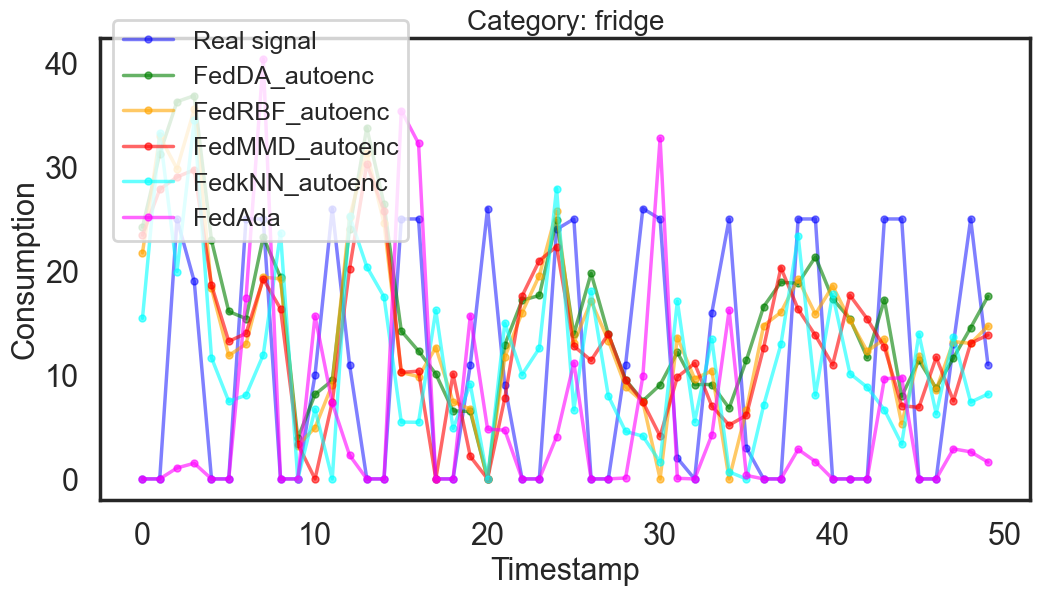

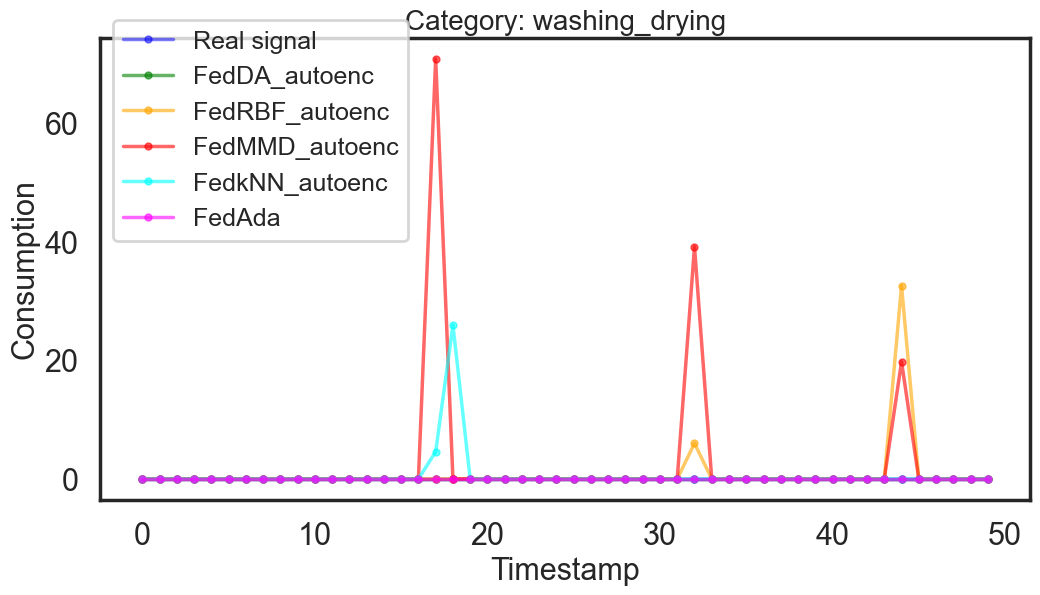

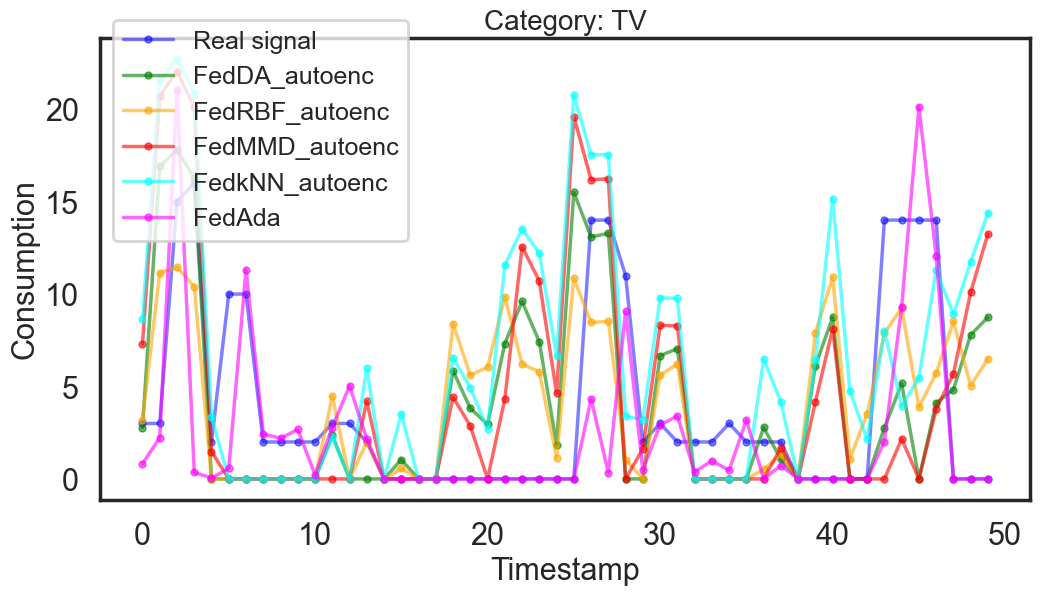

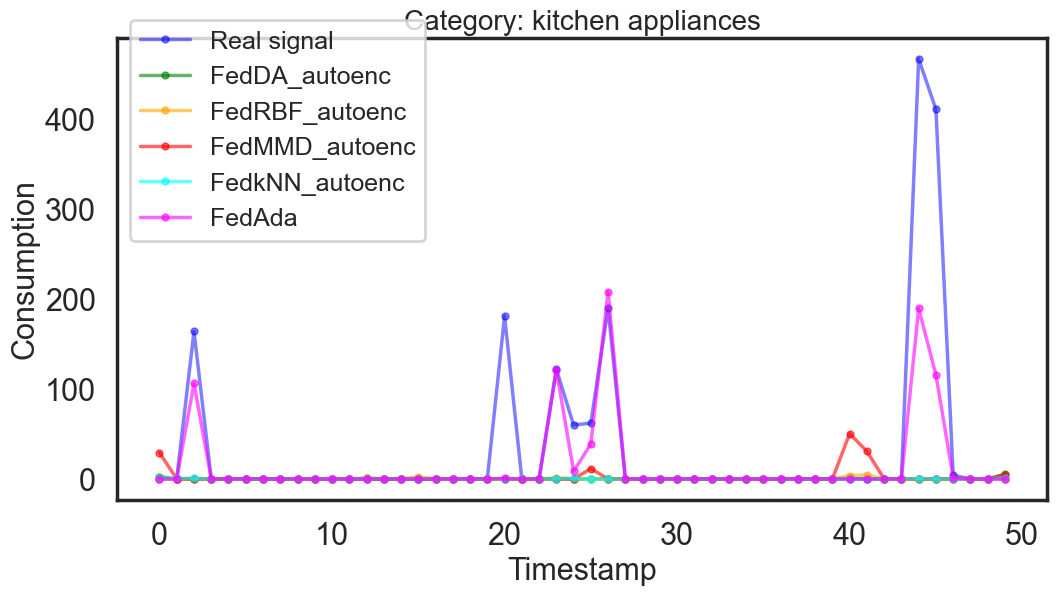

In [599]:
compare_method_plots_indiv(res, test,[
 'FedDA_autoenc',
 'FedRBF_autoenc',
 'FedMMD_autoenc',
 'FedkNN_autoenc',
 'FedAda'],i=1, data_type='test')

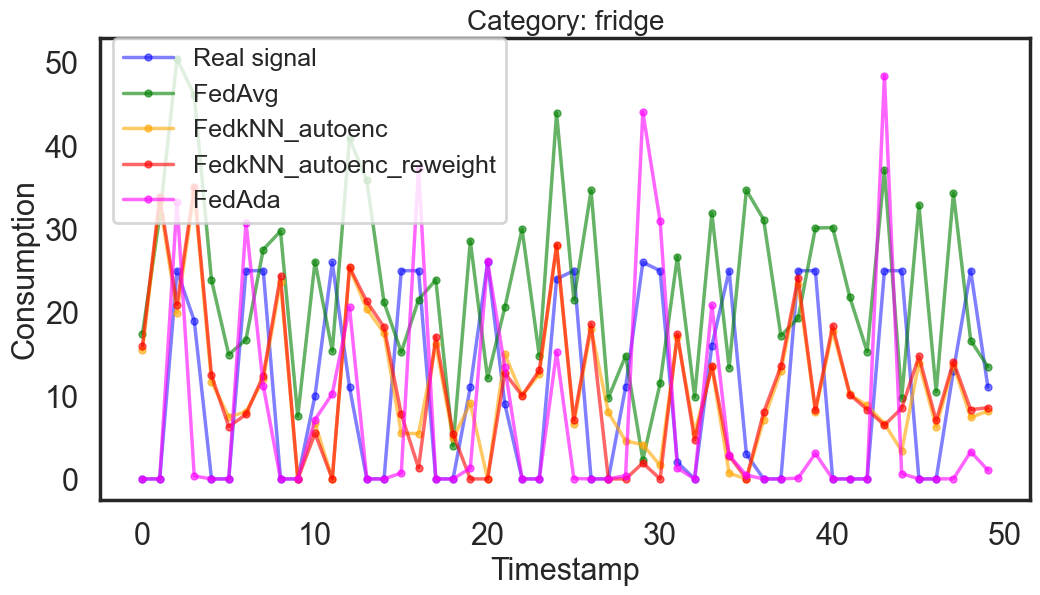

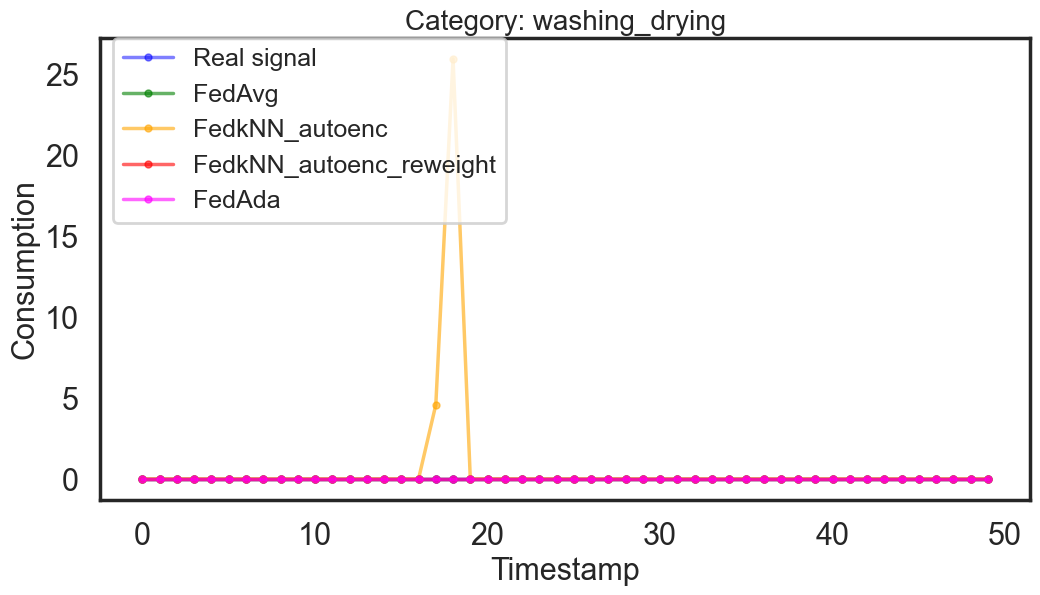

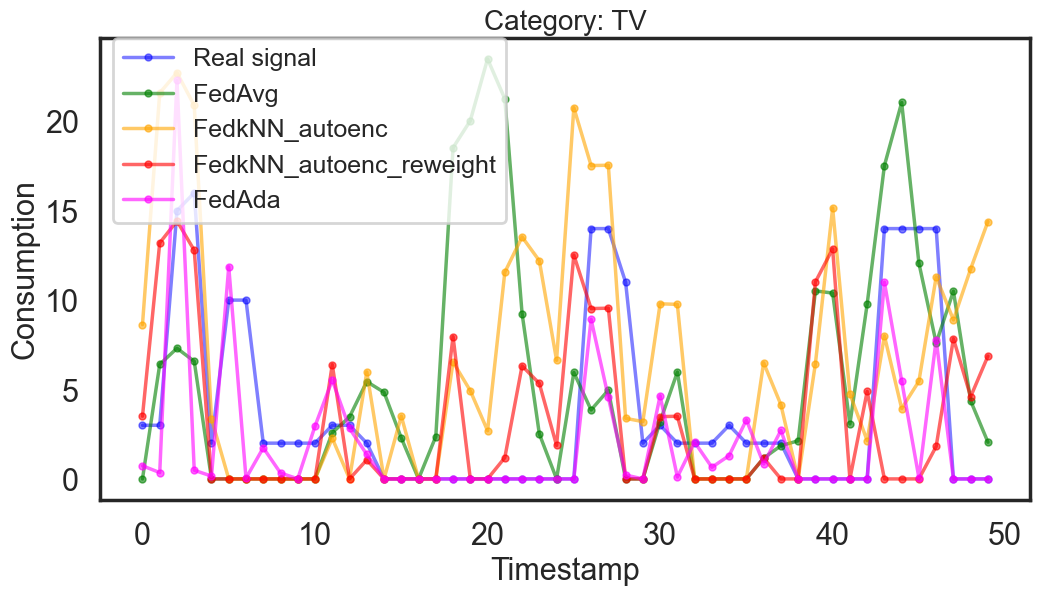

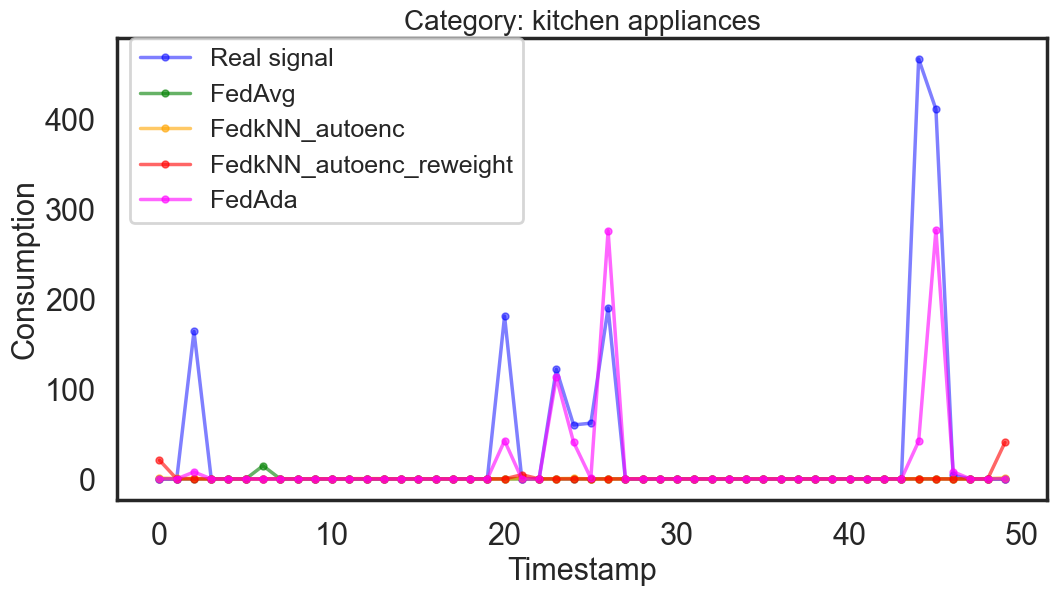

In [600]:
compare_method_plots_indiv(res, test, ['FedAvg', 'FedkNN_autoenc','FedkNN_autoenc_reweight','FedAda'], data_type='test')